# Site description plots

In [1]:
from pathlib import Path
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Read surface data
hyy_surf_data_path = Path(
    "../../data/case_input_data/HYY/surfdata_0.9x1.25_hist_16pfts_Irrig_CMIP6_simyr2000_HYY_c230403.nc"
)
surf_data = xr.open_dataset(hyy_surf_data_path)

In [3]:
surf_data

<xarray.Dataset>
Dimensions:                  (lsmlat: 1, lsmlon: 1, nlevsoi: 10, natpft: 15,
                              cft: 2, time: 12, lsmpft: 17, numurbl: 3,
                              numrad: 2, nlevurb: 5, nglcecp1: 11, nglcec: 10)
Coordinates:
  * natpft                   (natpft) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
  * cft                      (cft) int32 15 16
  * time                     (time) int32 1 2 3 4 5 6 7 8 9 10 11 12
  * lsmlon                   (lsmlon) float64 24.3
  * lsmlat                   (lsmlat) float64 61.85
Dimensions without coordinates: nlevsoi, lsmpft, numurbl, numrad, nlevurb,
                                nglcecp1, nglcec
Data variables: (12/83)
    zbedrock                 (lsmlat, lsmlon) float64 ...
    mxsoil_color             (lsmlat, lsmlon) int32 ...
    SOIL_COLOR               (lsmlat, lsmlon) int32 ...
    PCT_SAND                 (nlevsoi, lsmlat, lsmlon) float64 ...
    PCT_CLAY                 (nlevsoi, lsmlat, lsmlon) float64 ...
    ORGANIC                  (nlevsoi, lsmlat, lsmlon) float64 ...
    ...                       ...
    CONST_GRAZING            (lsmlat, lsmlon) float64 ...
    CONST_FERTNITRO_CFT      (cft, lsmlat, lsmlon) float64 ...
    UNREPRESENTED_PFT_LULCC  (natpft, lsmlat, lsmlon) float64 ...
    UNREPRESENTED_CFT_LULCC  (cft, lsmlat, lsmlon) float64 ...
    lon                      (lsmlat, lsmlon) float64 ...
    lat                      (lsmlat, lsmlon) float64 ...
Attributes: (12/51)
    Conventions:                          NCAR-CSM
    Source:                               Community Land Model: CLM5
    no_inlandwet:                         TRUE
    nglcec:                               10
    Input_grid_dataset:                   map_0.25x0.25_MODIS_to_0.9x1.25_nom...
    Input_gridtype:                       global
    ...                                   ...
    Created_on:                           2023-04-03
    Created_by:                           lassetk
    Created_with:                         ./subset_data -- 616905bbb
    Created_from:                         /cluster/shared/noresm/inputdata/ln...
    history:                              Fri Jun 30 16:27:13 2023: ncap2 -s ...
    NCO:                                  netCDF Operators version 5.0.6 (Hom...

In [4]:
# Retrieve percentage of PFTs that occur
active_pft_mask = (surf_data["PCT_NAT_PFT"].values > 0.0).flatten()
active_pft_mask

array([False,  True, False, False, False, False, False,  True, False,
       False, False, False, False,  True, False])

In [5]:
pft_names = {
    "0": "Bare ground",
    "1": "NET Temperate",
    "2": "NET Boreal",
    "3": "NDT Boreal",
    "4": "BET Tropical",
    "5": "BET temperate",
    "6": "BDT tropical",
    "7": "BDT temperate",
    "8": "BDT boreal",
    "9": "BES temperate",
    "10": "BDS temperate",
    "11": "BDS boreal",
    "12": "C3 arctic grass",
    "13": "C3 grass",
    "14": "C4 grass",
    "15": "C3 Unmanaged Rainfed Crop",
    "16": "C3 Unmanaged Irrigated Crop",
}

active_pft_pct_dict = {}

for pft, active, pct_cover in zip(
    pft_names.values(),
    active_pft_mask,
    surf_data["PCT_NAT_PFT"].values.flatten()
):
    if active: 
        print(f"{pft}: {round(pct_cover, 2)}% cover")
        active_pft_pct_dict[pft] = round(pct_cover, 3)

NET Temperate: 82.26% cover
BDT temperate: 10.65% cover
C3 grass: 7.1% cover


In [8]:
active_pft_pct_dict

{'NET Temperate': 82.258, 'BDT temperate': 10.645, 'C3 grass': 7.097}

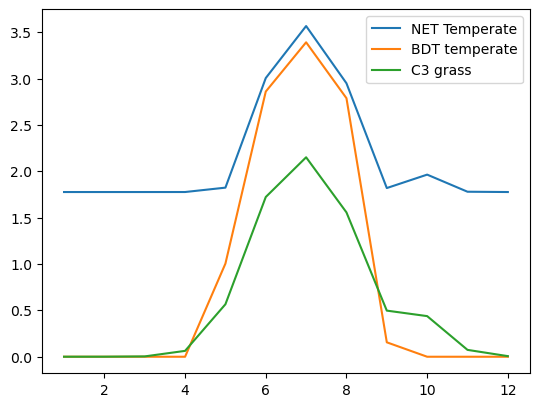

In [9]:
# Plot
fig, ax = plt.subplots(figsize=(16/2.54, 12/2.54))

max_lai_dict = {}

for (idx, pft_idx), is_active in zip(enumerate(surf_data["MONTHLY_LAI"].lsmpft), active_pft_mask):#enumerate(pft_names):

    if is_active:
        ax.plot(
            surf_data["time"],
            surf_data["MONTHLY_LAI"].sel(lsmpft=pft_idx).squeeze(),
            label=pft_names[str(idx)],
        )

        max_lai_dict[pft_names[str(idx)]] = max(surf_data["MONTHLY_LAI"].sel(lsmpft=pft_idx).values.squeeze())

ax.legend()

In [10]:
max_lai_dict

{'NET Temperate': 3.56846794542862,
 'BDT temperate': 3.392881889469361,
 'C3 grass': 2.1521949663142057}

In [11]:
# Scaled by area covered (IS THIS HOW IT IS DONE?)
prescribed_lai_dict = {}
for (pft_name, max_lai), prescribed_area in zip(
    max_lai_dict.items(), active_pft_pct_dict.values()
    ):
    prescribed_lai_dict[pft_name] = max_lai * (prescribed_area/100)

prescribed_lai_dict

{'NET Temperate': 2.935350362550674,
 'BDT temperate': 0.36117227713401345,
 'C3 grass': 0.1527412767593192}

---
# Make plot

In [12]:
# Read LAI data
lai_df = pd.read_csv(
    "./data/hyy_lai_samuli_vs_spmode.csv",
    index_col=0,
)
lai_df

,lai,entity,source
name,,,
LAI_pine_LAI_spruce,2.9113,species,Launiainen2022
LAI_deciduous,0.9856,species,Launiainen2022
PFT_needle,2.9400,species,fates_sp
PFT_deciduous,0.3600,species,fates_sp
PFT_grass,0.1500,species,fates_sp
total_allometry,3.8971,total,Launiainen2022
total_radiation,3.2577,total,Launiainen2022
total_fates_sp,3.4500,total,fates_sp


In [13]:
# Read country border geojson
country_gdf = gpd.read_file("./data/countries.geojson")
country_gdf.head()

,ADMIN,ISO_A3,geometry
0,Aruba,ABW,"POLYGON ((-69.99694 12.57758, -69.93639 12.531..."
1,Afghanistan,AFG,"POLYGON ((71.04980 38.40866, 71.05714 38.40903..."
2,Angola,AGO,"MULTIPOLYGON (((11.73752 -16.69258, 11.73851 -..."
3,Anguilla,AIA,"MULTIPOLYGON (((-63.03767 18.21296, -63.09952 ..."
4,Albania,ALB,"POLYGON ((19.74777 42.57890, 19.74601 42.57993..."


In [14]:
# Site coordinates for plot
hyy_coordinates = (24.3, 61.85)

In [15]:
# Get Finland bounds
minx, miny, maxx, maxy = country_gdf.loc[country_gdf["ADMIN"] == "Finland"].geometry.total_bounds
# Add a bit of space
minx, miny = minx-5, miny-2
maxx, maxy = maxx+5, maxy+2

In [16]:
# Create bounding box and clip countries inside
from shapely.geometry import box

bbox = box(minx, miny, maxx, maxy)
df_clipped = gpd.clip(country_gdf, mask=bbox)

In [17]:
df_clipped.head()

,ADMIN,ISO_A3,geometry
169,Norway,NOR,"MULTIPOLYGON (((15.93019 68.00825, 15.93295 68..."
191,Russia,RUS,"MULTIPOLYGON (((29.78688 59.97508, 29.73365 59..."
215,Sweden,SWE,"MULTIPOLYGON (((18.80348 57.82575, 18.81072 57..."
138,Latvia,LVA,"POLYGON ((25.33988 58.03258, 25.34639 58.03444..."
72,Estonia,EST,"MULTIPOLYGON (((23.22055 57.81769, 23.22429 57..."


/tmp/ipykernel_2798339/1977055991.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels(
/tmp/ipykernel_2798339/1977055991.py:70: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(


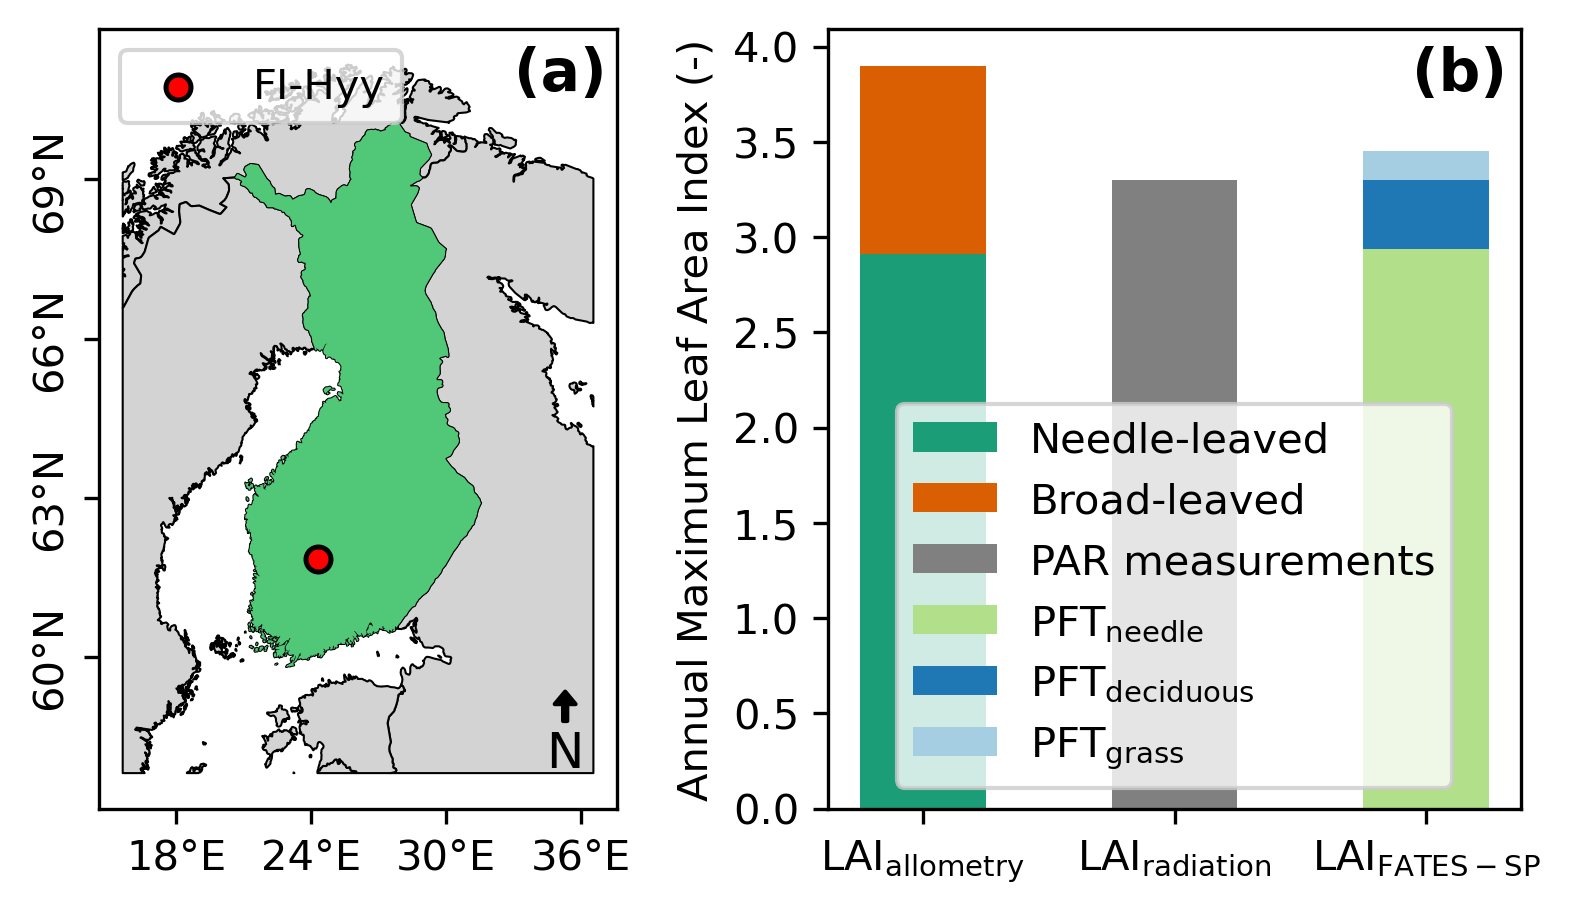

In [34]:
save = True

import matplotlib.text as mtext

class LegendTitle(object):
    def __init__(self, text_props=None):
        self.text_props = text_props or {}
        super(LegendTitle, self).__init__()

    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        title = mtext.Text(x0, y0, r'\underline{' + orig_handle + '}', usetex=True, **self.text_props)
        handlebox.add_artist(title)
        return title

fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(14/2.54, 8/2.54),
    dpi=300,
)

df_clipped.plot(
    ax=axes[0],
    color="lightgray",
    linewidth=0.5,
    edgecolor='black',
)

country_gdf.loc[country_gdf["ADMIN"] == "Finland"].plot(
    ax=axes[0],
    color="#50c878",
    zorder=1
)
axes[0].scatter(
    hyy_coordinates[0],
    hyy_coordinates[1],
    marker="o",
    color="red",
    edgecolor="black",
    linewidths=1.2,
    label="FI-Hyy",
    zorder=2
)

# North arrow
arrow_x, arrow_y, arrow_length = 0.9, 0.15, 0.11
axes[0].annotate(
    'N', xy=(arrow_x, arrow_y),
    xytext=(arrow_x, arrow_y-arrow_length),
    arrowprops=dict(
        facecolor='black',
        edgecolor="black",
        linewidth=1,
        width=1,
        headwidth=5,
        headlength=3,
    ),
    ha='center', va='bottom', fontsize=12,
    xycoords=axes[0].transAxes
)

axes[0].yaxis.set_major_locator(plt.MaxNLocator(5))
axes[0].xaxis.set_major_locator(plt.MaxNLocator(4))
axes[0].set_yticklabels(
    [f"{x.get_text()}°N" for x in axes[0].get_yticklabels()],
    rotation=90,
    va="center"
)
axes[0].set_xticklabels(
    [f"{x.get_text()}°E" for x in axes[0].get_xticklabels()]
)
axes[0].legend(loc="upper left")


# LAI SUBPLOT

sources = (
    "LAI$_{\mathrm{allometry}}$",
    "LAI$_{\mathrm{radiation}}$",
    "LAI$_{\mathrm{FATES-SP}}$",
)

allometry_fractions = {
    "Needle-leaved": {
        "value": lai_df.loc["LAI_pine_LAI_spruce", "lai"],#2.9,
        "color": "#1b9e77"
    },
    "Broad-leaved": {
        "value": lai_df.loc["LAI_deciduous", "lai"],#1.0,
        "color": "#d95f02"
    }
}

# ALLOMETRY
width = 0.5

bottom = 0

biomass_inventory_barplot_list = []

for taxa, weight_count in allometry_fractions.items():
    biomass_inventory_barplot_list.append(
        axes[1].bar(
            sources[0],
            weight_count["value"],
            width,
            label=taxa,
            bottom=bottom,
            color=weight_count["color"]
        )
    )
    bottom += weight_count["value"]

# RADIATION
p2 = axes[1].bar(
    sources[1],
    3.3,
    width,
    label="PAR measurements",
    bottom=0,
    color="gray"
)

# FATES-SP
fates_sp_fractions = {
    "PFT$_{\mathrm{needle}}$": {
        "value": lai_df.loc["PFT_needle", "lai"],#2.94,
        "color": "#b2df8a",
    },
    "PFT$_{\mathrm{deciduous}}$": {
        "value": lai_df.loc["PFT_deciduous", "lai"],#0.36,
        "color": "#1f78b4",
    },
    "PFT$_{\mathrm{grass}}$": {
        "value": lai_df.loc["PFT_grass", "lai"],#0.15,
        "color": "#a6cee3",
    },
}

bottom = 0

for boolean, weight_count in fates_sp_fractions.items():
    p = axes[1].bar(sources[2], weight_count["value"], width, label=boolean, bottom=bottom, color=weight_count["color"])
    bottom += weight_count["value"]

# Create subheadings for the legend
'''
legend_subheading1 = plt.Line2D(
    [0], [0], linestyle='none', marker='o', markersize=10,
    label='Biomass inventory',
    color='w'
)
legend_subheading2 = plt.Line2D(
    [0], [0], linestyle='none', marker='s', markersize=10,
    label='FATES-SP',
    color='w'
)
'''

# Add label and legend
axes[1].set_ylabel('Annual Maximum Leaf Area Index (-)')

axes[1].legend(
    loc='lower center',
)

'''
axes[1].legend(
    handles=[
        biomass_inventory_barplot_list[0],
        biomass_inventory_barplot_list[1],
        legend_subheading1,
        legend_subheading2
    ],
    labels=['Group 1', 'Group 2', 'Subheading 1', 'Subheading 2'],
    loc='lower center',
)

axes[1].legend(
    ['Biomass inventory', line1, 'Title 2', line2],
    ['', 'Line 1', '', 'Line 2'],
    handler_map={str: LegendTitle({'fontsize': 18})},
    loc='lower center',
    ncols=1
)
'''


# Add figure numbers
axes[0].text(
    0.98, 0.98,
    "(a)",
    ha='right',
    va='top',
    transform=axes[0].transAxes,
    fontsize=14,
    fontweight='demibold',
)
axes[1].text(
    0.98, 0.98,
    "(b)",
    ha='right',
    va='top',
    transform=axes[1].transAxes,
    fontsize=14,
    fontweight='demibold',
)

fig.tight_layout()

# Save figure
if save:
    fig.savefig(
        "../../data/results/plots/site_info/hyy_location_and_lai.png"
    )